In [1]:
from astropy.io import fits
from astropy.table import Table
import numpy as np 
import matplotlib.pyplot as plt

# WASP-52 from NIRSPEC with different filters

In [2]:
hdul = fits.open("./data/wasp52/jw03969-o003_t002_nirspec_f290lp-g395h-sub2048_x1dints.fits")
hdul.info()

Filename: ./data/wasp52/jw03969-o003_t002_nirspec_f290lp-g395h-sub2048_x1dints.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     357   ()      
  1  INT_TIMES     1 BinTableHDU     24   616R x 7C   [J, D, D, D, D, D, D]   
  2  EXTRACT1D     1 BinTableHDU     85   1273R x 18C   [D, D, D, D, D, D, D, D, D, D, D, J, D, D, D, D, D, D]   
  3  EXTRACT1D     2 BinTableHDU     81   1273R x 18C   [D, D, D, D, D, D, D, D, D, D, D, J, D, D, D, D, D, D]   
  4  EXTRACT1D     3 BinTableHDU     81   1273R x 18C   [D, D, D, D, D, D, D, D, D, D, D, J, D, D, D, D, D, D]   
  5  EXTRACT1D     4 BinTableHDU     81   1273R x 18C   [D, D, D, D, D, D, D, D, D, D, D, J, D, D, D, D, D, D]   
  6  EXTRACT1D     5 BinTableHDU     81   1273R x 18C   [D, D, D, D, D, D, D, D, D, D, D, J, D, D, D, D, D, D]   
  7  EXTRACT1D     6 BinTableHDU     81   1273R x 18C   [D, D, D, D, D, D, D, D, D, D, D, J, D, D, D, D, D, D]   
  8  EXTRACT1D     7 BinTableHDU     81 

In [3]:
hdul[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
DATE    = '2024-11-03T10:43:09.507' / UTC date file created                     
ORIGIN  = 'STSCI   '           / Organization responsible for creating file     
TIMESYS = 'UTC     '           / principal time system for time-related keywords
TIMEUNIT= 's       '           / Default unit applicable to all time values     
FILENAME= 'jw03969-o003_t002_nirspec_f290lp-g395h-sub2048_x1dints.fits' / Name o
SDP_VER = '2024_2b '           / Data processing (DP) Software Version          
PRD_VER = 'PRDOPSSOC-067'      / S&OC Project Reference Database (PRD) Version  
OSS_VER = '009.000.000.000'    / Observatory Scheduling Software (OSS) Version  
GSC_VER = 'GSC30   '        

Data is structured differently depending on which instrument etc. Lets make a function first to extract the data more easily

In [4]:
from math import ceil

def process_data(hdul):
    header = hdul[0].header
    num_integrations = header["NINTS"]
    integration_end = header["INTEND"] 
    wavelength_bins = (len(hdul) - 3)//num_integrations # -3 because of PrimaryHDU, integration times HDU, and trailing ASDF table
    # Due to chosen Grating, it creates a gap in the range of wavelength measured (see https://jwst-docs.stsci.edu/jwst-near-infrared-spectrograph/nirspec-operations/nirspec-bots-operations/nirspec-bots-wavelength-ranges-and-gaps#gsc.tab=0) 
    #NOTE i think this is the reason the data is split, have to verify with data using gratings that don't have the gap
    #NOTE Physically it happens due to the chosen resolution and the physical gap between the two sensors on-board, 
    #NOTE hence why it doesn't happen for lower resolution gratings, because the full spectrum falls in a single detector.
    #NOTE The function can be generalized using the above information, but for now its okay

    # If there is only one wavelength bin, simply return all datasets
    if wavelength_bins == 1:
        return hdul[2:-2]

    idx_dict: dict[int, np.ndarray] = {}
    start_idx = 0
    for idx in range(0, ceil(num_integrations/integration_end) * wavelength_bins):
        bin = idx % wavelength_bins
        step = (idx - bin)//wavelength_bins
        if bin not in idx_dict:
            idx_dict[bin] = np.zeros((num_integrations,), dtype=int)

        if (step+1)*integration_end < num_integrations:
            idx_dict[bin][step*integration_end:(step+1)*integration_end]  = np.asarray(range(2+start_idx, 2+start_idx+integration_end))
            start_idx = start_idx+integration_end
        else:
            idx_dict[bin][step*integration_end:num_integrations] = np.asarray(range(2+start_idx, 2+start_idx + num_integrations - integration_end))
            start_idx = start_idx + num_integrations - integration_end
    
    return idx_dict
    
def get_data(hdul, wavelength_bin: int = 1):
    header = hdul[0].header
    num_integrations = header["NINTS"]
    wavelength_bins = (len(hdul) - 3)//num_integrations

    if wavelength_bin > wavelength_bins:
        raise ValueError(f"Only {wavelength_bins} exists within the dataset, please select on of those.")

    idx_dict = process_data(hdul)

    ret = []
    for idx in idx_dict[wavelength_bin - 1]:
        ret.append(Table(hdul[idx].data))
    return ret


data1 = get_data(hdul, wavelength_bin=1)
data2 = get_data(hdul, wavelength_bin=2)

## Analysis of the first wavelength range

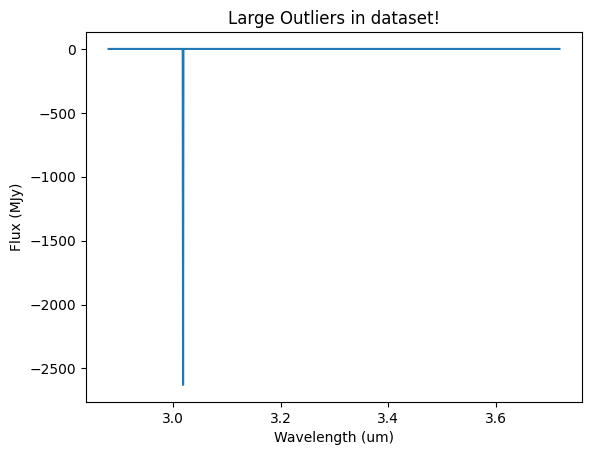

In [5]:
tab_data1 = data1[0]

plt.plot(tab_data1["WAVELENGTH"], tab_data1["FLUX"])
#plt.ylim(0,0.04)
plt.title("Large Outliers in dataset!")
plt.xlabel("Wavelength (um)")
plt.ylabel("Flux (MJy)")
plt.show()

In [6]:
# Filter outliers
def filter_outliers(table_data: Table, tolerance: float = 10.0) -> None:
    """
    Function to filter outliers based on flux error. Set datapoints with too high a flux error to NaN
    """
    prev_median_error = 1000000
    median_error = 1000
    while (1 - median_error/prev_median_error) > 0.1: 
        prev_median_error = median_error
        median_error = np.median(table_data["FLUX_ERROR"][~np.isnan(table_data["FLUX_ERROR"])])
        indx = np.where(table_data["FLUX_ERROR"] > (tolerance * median_error))
        table_data["FLUX"][indx] = np.nan 
        table_data["FLUX_ERROR"][indx] = np.nan


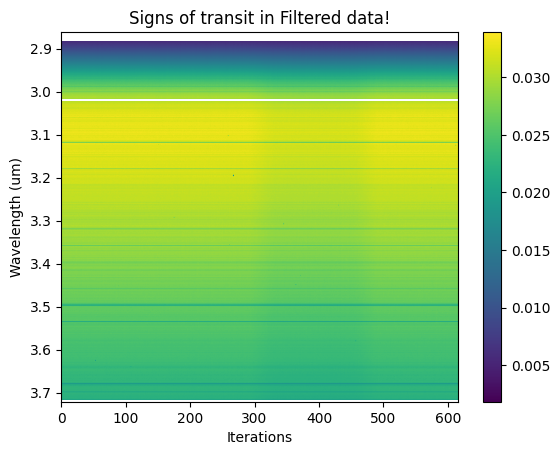

In [7]:
data = np.zeros((len(data1),len(data1[0])))
for idx, tab_data in enumerate(data1):
    filter_outliers(tab_data)
    data[idx, :] = tab_data["FLUX"]

plt.imshow(data.T, extent=[0, len(data1), tab_data["WAVELENGTH"][-1], tab_data["WAVELENGTH"][0]], aspect="auto")
plt.colorbar()
plt.title("Signs of transit in Filtered data!")
plt.xlabel("Iterations")
plt.ylabel("Wavelength (um)")
plt.show()

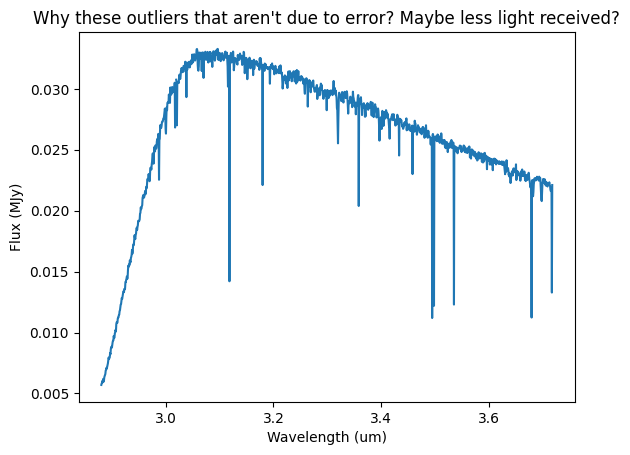

In [8]:
table_data = data1[0]
filter_outliers(table_data)
plt.plot(table_data["WAVELENGTH"], table_data["FLUX"])
plt.title("Why these outliers that aren't due to error? Maybe less light received?")
plt.xlabel("Wavelength (um)")
plt.ylabel("Flux (MJy)")
plt.show()

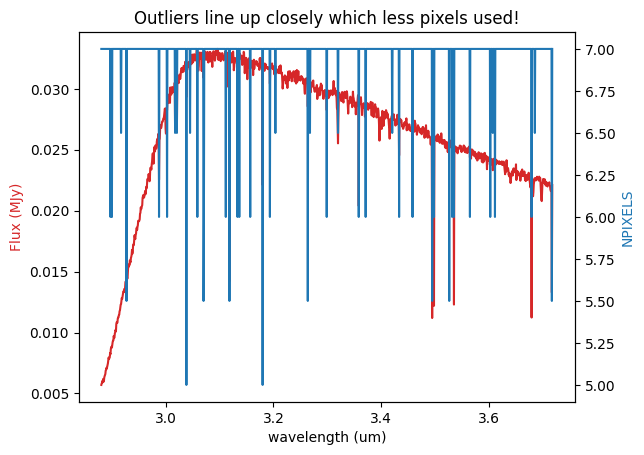

In [9]:
fig, ax1 = plt.subplots()

color = "tab:red"
ax1.set_xlabel('wavelength (um)')
ax1.set_ylabel('Flux (MJy)', color=color)
ax1.plot(table_data["WAVELENGTH"], table_data["FLUX"], color=color)

ax2 = ax1.twinx()
color  = "tab:blue"
ax2.set_ylabel("NPIXELS", color=color)
ax2.plot(table_data["WAVELENGTH"][table_data["NPIXELS"] > 0], table_data["NPIXELS"][table_data["NPIXELS"] > 0], color=color)

plt.title("Outliers line up closely which less pixels used!")
plt.show()


Looking closely at the above plot, outliers (can) occur when less than the maximum amount of pixels was used. For first exploration, simply remove (set to NaN) those entries that do not use the full amount of pixels. It should be noted that these outliers may not be outliers at all, but simply the absorption lines of the star!

In [10]:
def filter_outliers2(table_data: Table, tolerance=10.0):
    filter_outliers(table_data, tolerance=tolerance)
    max_pixels = np.max(table_data["NPIXELS"])
    indx = np.where(table_data["NPIXELS"] < max_pixels)
    table_data["FLUX"][indx] = np.nan
    table_data["FLUX_ERROR"][indx] = np.nan

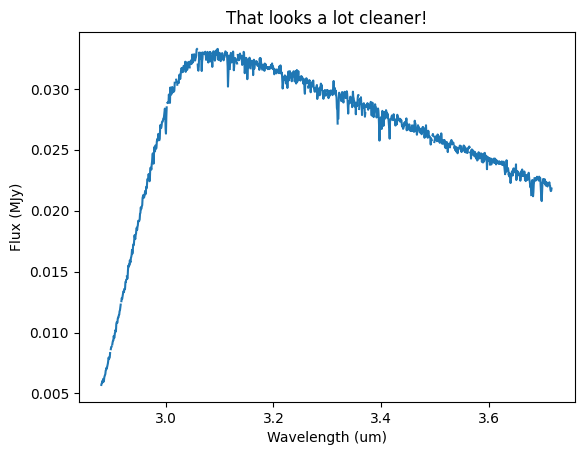

In [11]:
table_data = data1[0]
filter_outliers2(table_data)
plt.plot(table_data["WAVELENGTH"], table_data["FLUX"])
plt.title("That looks a lot cleaner!")
plt.xlabel("Wavelength (um)")
plt.ylabel("Flux (MJy)")
plt.show()

Lets plot the filtered again as a 2D image

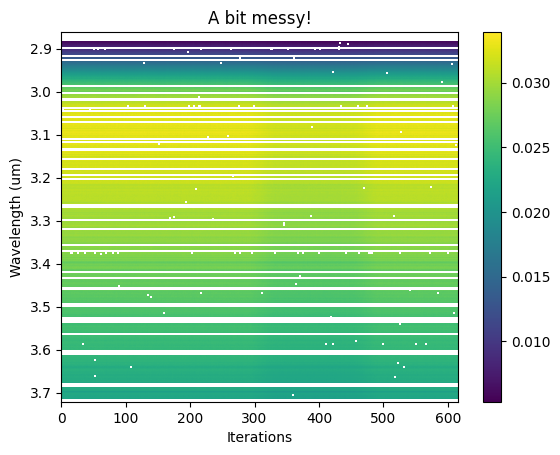

In [12]:
data = np.zeros((len(data1),len(data1[0])))
for idx, tab_data in enumerate(data1):
    filter_outliers2(tab_data)
    data[idx, :] = tab_data["FLUX"]

plt.imshow(data.T, extent=[0, len(data1), table_data["WAVELENGTH"][-1], table_data["WAVELENGTH"][0]], aspect="auto")
plt.colorbar()
plt.title("A bit messy!")
plt.xlabel("Iterations")
plt.ylabel("Wavelength (um)")
plt.show()

Lets clean that up by linear interpolation between adjacent points that are not NaN

In [13]:
def cleanup_data(table_data: Table):
    # Filter outliers first
    filter_outliers2(table_data)

    # Get all the indices which are NaN and not NaN seperately
    indxs_not_nan = np.where(~np.isnan(table_data["FLUX"]))[0]
    indxs_nan = np.where(np.isnan(table_data["FLUX"]))[0]

    # Find all the start and end indices of gaps within the data
    start_end_tuples_list = []
    start_idx = indxs_not_nan[0]
    while start_idx < indxs_not_nan[-1]:
        # Find first index greater than start idx that is NaN
        idx = indxs_nan[np.where(indxs_nan > start_idx )[0][0]]

        # Start index will be one less than the first new NaN 
        idx_start = idx  -1

        # The end index will be the first non-NaN index greater than the new Nan index
        idx_end = indxs_not_nan[np.where(indxs_not_nan > idx)[0]][0]

        # Add start and end indices to list
        start_end_tuples_list.append((idx_start, idx_end))

        # The new start index will be the end index of the current run
        start_idx = idx_end

    # For each gap, use linear interpolation to fill the gaps
    for idx_start, idx_end in start_end_tuples_list:
        missing_idxs = np.asarray(range(idx_start+1, idx_end))
        missing_wavelengths = table_data["WAVELENGTH"][missing_idxs].data
        flux_start, flux_end = table_data["FLUX"][idx_start], table_data["FLUX"][idx_end]
        wvl_start, wvl_end = table_data["WAVELENGTH"][idx_start], table_data["WAVELENGTH"][idx_end]

        missing_fluxes = flux_start + (flux_end - flux_start)/(wvl_end - wvl_start)*(missing_wavelengths - wvl_start)
        table_data["FLUX"][missing_idxs] = missing_fluxes

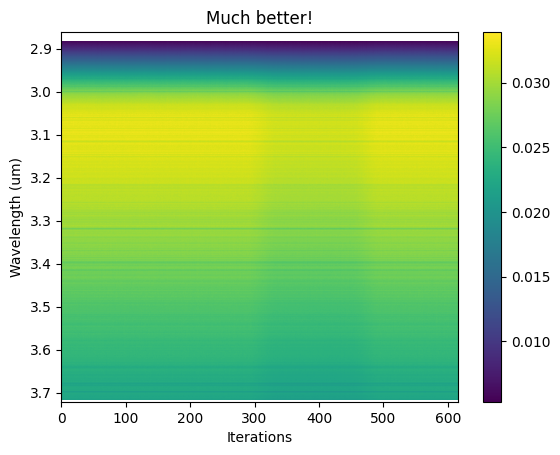

In [14]:
data = np.zeros((len(data1),len(data1[0])))
for idx, tab_data in enumerate(data1):
    cleanup_data(tab_data)
    data[idx, :] = tab_data["FLUX"]

plt.imshow(data.T, extent=[0, len(data1), tab_data["WAVELENGTH"][-1], tab_data["WAVELENGTH"][0]], aspect="auto")
plt.colorbar()
plt.title("Much better!")
plt.xlabel("Iterations")
plt.ylabel("Wavelength (um)")
plt.show()

Lets integrate the filtered data to obtain a transit curve

In [15]:
from scipy.integrate import simpson

def integrate(table_data: Table) -> float:
    # Filter first
    cleanup_data(table_data)

    # Remove all NaNs while ensuring the corresponding wavelength bins are also removed
    indx = np.where(~np.isnan(table_data["FLUX"]))
    wvl = table_data["WAVELENGTH"][indx]
    flux = table_data["FLUX"][indx]
    return simpson(flux, x=wvl)

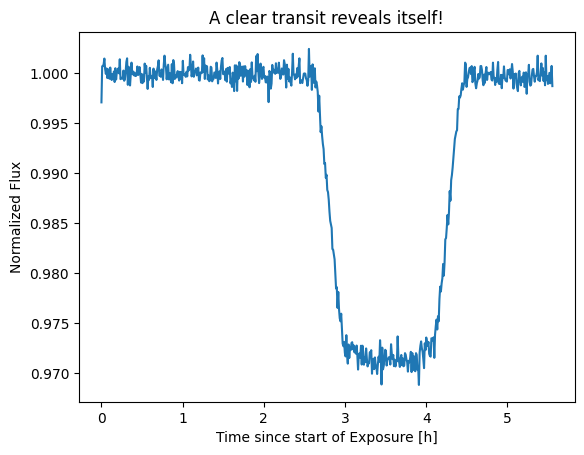

In [16]:
data = np.zeros((len(data1),1))
for idx, tab_data in enumerate(data1):
    data[idx] = integrate(tab_data)

plt.plot((Table(hdul[1].data)["int_mid_MJD_UTC"] - hdul[0].header["EXPSTART"])*24, data/data[10])
plt.xlabel("Time since start of Exposure [h]")
plt.ylabel("Normalized Flux")
plt.title("A clear transit reveals itself!")
plt.show()

Now that its clear when the transit occurs, one can subtract the spectrum during the transit from the spectrum when the planet is not transiting, to obtain a spectrum of the light blocked by the atmosphere of the planet, if it exists.

Of course, ideally, you would want to compare with a spectra of the star when the planet is eclipsed by its star, to remove any emissions from the planet itself (such a blackbody emissions). For now lets just forget about that and be naive. It should be noted that it is known that WASP-52b is a hot jupiter, so its night side emissions will have a significant blackbody contribution. 

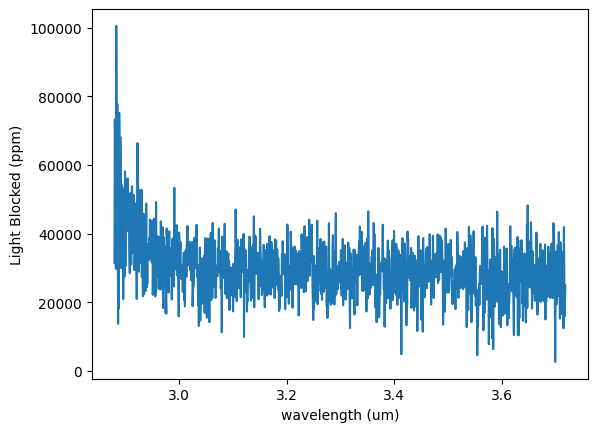

In [17]:
transit_spectra = data1[400]["FLUX"]
non_transit_spectra = data1[2]["FLUX"]

ydata = (1 - transit_spectra/non_transit_spectra)*1e6
xdata = data1[0]["WAVELENGTH"]
plt.plot(xdata, ydata)
plt.xlabel("wavelength (um)")
plt.ylabel("Light Blocked (ppm)")
plt.show()

The above data is produced without any regard of the uncertainties in any of the data (except for the filtering of outliers). Lets try to extract the uncertainty of the blocked light  

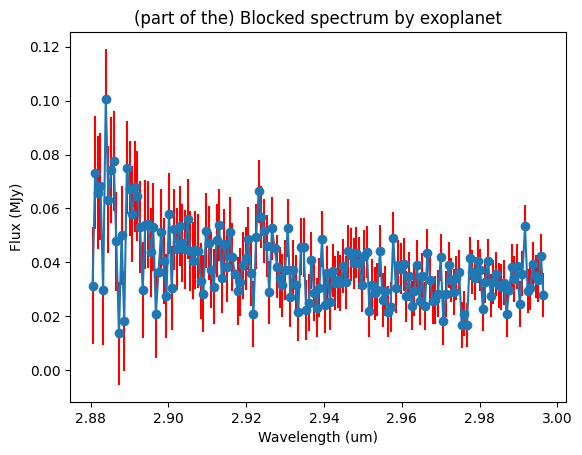

In [18]:
transit_spectra = data1[400]["FLUX"]
transit_spectra_error = data1[400]["FLUX_ERROR"]
non_transit_spectra = data1[2]["FLUX"]
non_transit_spectra_error = data1[2]["FLUX_ERROR"]

R =  1 - transit_spectra/non_transit_spectra
sR = np.sqrt((1/non_transit_spectra**2)*transit_spectra_error**2 + (transit_spectra**2/non_transit_spectra**4)*non_transit_spectra_error**2)

plt.errorbar(data1[400]["WAVELENGTH"][0:200], R[0:200], sR[0:200], ecolor="red", fmt="o-")
plt.title("(part of the) Blocked spectrum by exoplanet")
plt.xlabel("Wavelength (um)")
plt.ylabel("Flux (MJy)")
plt.show()


It is possible to compute this blocked light spectra for many combinations of transiting and non-transiting measurements. Combining these combinations should result in a clear spectra that can be used for atmospheric composition analysis

c:\Users\dbrinkman1\Documents\python_tests\phdtest\code\astropy\.venv\lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\dbrinkman1\Documents\python_tests\phdtest\code\astropy\.venv\lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\dbrinkman1\Documents\python_tests\phdtest\code\astropy\.venv\lib\site-packages\numpy\_core\_methods.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\dbrinkman1\Documents\python_tests\phdtest\code\astropy\.venv\lib\site-packages\numpy\_core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\dbrinkman1\Documents\python_tests\phdtest\code\astropy\.venv\lib\site-packages\numpy\_core\_methods.py:219: RuntimeWarn

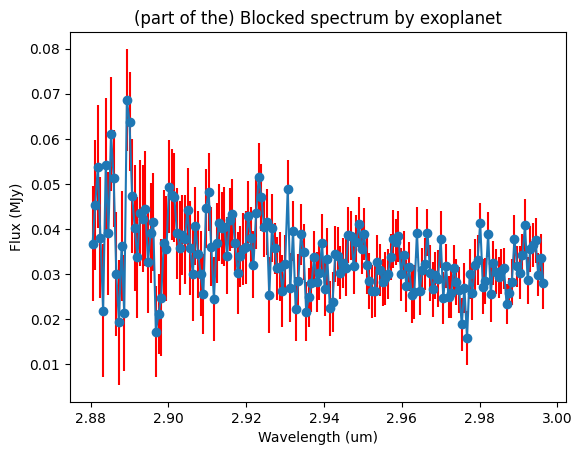

In [19]:
transit_spectra = data1[400]["FLUX"].data
transit_spectra_error = data1[400]["FLUX_ERROR"].data

# Take the first 100 entries of the data to be subset of non-transiting spectra
dataR = np.zeros((100, len(transit_spectra)))
for idx in range(0, 100):
    non_transit_spectra = data1[idx]["FLUX"].data
    non_transit_spectra_error = data1[idx]["FLUX_ERROR"].data
    dataR[idx,:] = 1 - transit_spectra/non_transit_spectra

# Using statistical methods to compute a mean and standard deviation
#NOTE still not using the uncertanties of the original spectra!
dataRavg = np.zeros((len(transit_spectra),))
datasR = np.zeros((len(transit_spectra),))
for idx in range(0, len(transit_spectra)):
    dataRavg[idx] = np.mean(dataR[:, idx][~np.isnan(dataR[:, idx])])
    datasR[idx] = np.std(dataR[:, idx][~np.isnan(dataR[:, idx])])

plt.errorbar(data1[400]["WAVELENGTH"].data[0:200], dataRavg[0:200], yerr=datasR[0:200], ecolor="red", fmt="o-")
plt.title("(part of the) Blocked spectrum by exoplanet")
plt.xlabel("Wavelength (um)")
plt.ylabel("Flux (MJy)")
plt.show()



As can be shown from the above two plots, combining the data did reduce the uncertainties of the spectra. 

Note that more advanced statistical estimations can be used to give better estimations of the true value and uncertainties involved by using not only the flux values, but also considering their uncertainties as well. 

#TODO

## Analysis of the second wavelength range

In [20]:
#TODO